<a href="https://colab.research.google.com/github/priscillaoclark/15.773-hands-on-deep-learning/blob/main/HODL_SP25_Recitation_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### We will get started at 10:05!

# Deep Learning for Text - The Transformer Encoder



## Introduction



In the previous module we studied an application of NLP that consisted essentially in classifying text. We saw that bag of words and bigrams (with a bit of help of word embeddings) were very useful for this task. In this module we will focus on a different class of task for which we'll need to develop different models and neural network architectures.

The type of tasks we are thinking about involve:
- "What should be the next word in this incomplete sentence?" (language modeling)
- "What are the components of a sentence?" (Named Entity Recognition)
- "What's the purpose of a query?" (Intent Prediction)
- "What are the key words in query?" (Slot Filing)

In this notebook we will tackle the last two tasks above. Natural Language Understanding (NLU), the technology behind conversational AI (chatbots, virtual assistant, augmented analytics) typically includes the intent classification and slot filling tasks, aiming to provide a semantic tool for user utterances. Intent classification focuses on predicting the intent of the query, while slot filling extracts semantic concepts in the query. For example the user query could be “Find me an action movie by Steven Spielberg”. The intent here is “find_movie” while the slots are “genre” with value “action” and “directed_by” with value “Steven Spielberg”.

For this module we will use the ATIS dataset which includes queries from people trying to find flight tickets between two destinations. The task will be to read this raw query and understand:
- what is the intent of the query (find availability of flight, duration of flight, ground transportation service),
- what are components or slots of that query (which airports or cities, what days and time).

## Data Preprocessing



Let's begin extracting the data from the ATIS dataset and turning into a form that we can use in our Deep Learning models.

The ATIS dataset is standard benchmark dataset widely used to build models for intent classification and slot filling tasks (we will explain all this shortly). You can find a very detailed explanation [here](https://catalog.ldc.upenn.edu/docs/LDC93S4B/corpus.html).

We will begin by loading the file and then partitioning into a test and a training set.

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

keras.utils.set_random_seed(42)

In [ ]:
train_url = "https://www.dropbox.com/scl/fi/m2yj95tccxmzin3mnna47/atis_train_data.csv?rlkey=p61rpu2mwxjcb1ypfh89qzull&st=omw3dkpu&dl=1"
test_url = "https://www.dropbox.com/scl/fi/d1zwrv2jslo7j93p68l75/atis_test_data.csv?rlkey=0kl75tt54i2ccau9m1fxevlhn&st=w7n0orza&dl=1"

In [ ]:
df_train = pd.read_csv(train_url, index_col=0)
df_test = pd.read_csv(test_url, index_col=0)

In [ ]:
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4978 entries, 0 to 4977
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   query         4978 non-null   object
 1   intent        4978 non-null   object
 2   slot filling  4978 non-null   object
dtypes: object(3)
memory usage: 155.6+ KB
None


In [ ]:
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
Index: 893 entries, 0 to 892
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   query         893 non-null    object
 1   intent        893 non-null    object
 2   slot filling  893 non-null    object
dtypes: object(3)
memory usage: 27.9+ KB
None


In [ ]:
df_train.head()

,query,intent,slot filling
0,i want to fly from boston at 838 am and arriv...,flight,O O O O O B-fromloc.city_name O B-depart_time...
1,what flights are available from pittsburgh to...,flight,O O O O O B-fromloc.city_name O B-toloc.city_...
2,what is the arrival time in san francisco for...,flight_time,O O O B-flight_time I-flight_time O B-fromloc...
3,cheapest airfare from tacoma to orlando,airfare,B-cost_relative O O B-fromloc.city_name O B-t...
4,round trip fares from pittsburgh to philadelp...,airfare,B-round_trip I-round_trip O O B-fromloc.city_...


The first column of the Dataframe below contains the actual query that was asked. The second column indicates the intent (flight, flight time, etc), whereas the last column contains the slot filling structure.

In [ ]:
query_data_train = df_train['query'].values
intent_data_train = df_train['intent'].values
slot_data_train = df_train['slot filling'].values

query_data_test = df_test['query'].values
intent_data_test = df_test['intent'].values
slot_data_test = df_test['slot filling'].values

In [ ]:
max_query_length = 30

In [ ]:
# Textvec of query

# define text_vectorization layer
text_vectorization_query = keras.layers.TextVectorization(
    output_sequence_length=max_query_length
)

# run training corpus through layer to create vocab
text_vectorization_query.adapt(query_data_train)
query_vocab_size = text_vectorization_query.vocabulary_size()

In [ ]:
text_vectorization_query.vocabulary_size()

888

In [ ]:
text_vectorization_query.get_vocabulary()[:20]

['',
 '[UNK]',
 'to',
 'from',
 'flights',
 'the',
 'on',
 'what',
 'me',
 'flight',
 'boston',
 'show',
 'san',
 'i',
 'denver',
 'a',
 'francisco',
 'in',
 'and',
 'atlanta']

In [ ]:
# vectorize train and test queries
source_train = text_vectorization_query(query_data_train)
source_test = text_vectorization_query(query_data_test)

Next, we need to do STIE for the output side of the problem i.e. the slots

Let's take another look at the slots.


In [ ]:
df_train['intent'].value_counts()

,count
intent,
flight,3666
airfare,423
ground_service,255
airline,157
abbreviation,147
aircraft,81
flight_time,54
quantity,51
flight+airfare,21


Note the - and . in the entity names 👆. We don't want the standardization to strip those out. Nor do we want to lower-case the names.

In [ ]:
# Textvec of slots
text_vectorization_slots = keras.layers.TextVectorization(
    output_sequence_length=max_query_length,
    standardize=None
)
text_vectorization_slots.adapt(slot_data_train)
slot_vocab_size = text_vectorization_slots.vocabulary_size()

target_train = text_vectorization_slots(slot_data_train)
target_test = text_vectorization_slots(slot_data_test)

In [ ]:
text_vectorization_slots.get_vocabulary()

['',
 '[UNK]',
 'O',
 'B-toloc.city_name',
 'B-fromloc.city_name',
 'I-toloc.city_name',
 'B-depart_date.day_name',
 'B-airline_name',
 'I-fromloc.city_name',
 'B-depart_time.period_of_day',
 'I-airline_name',
 'B-depart_date.day_number',
 'B-depart_date.month_name',
 'B-depart_time.time',
 'B-round_trip',
 'B-cost_relative',
 'I-round_trip',
 'B-flight_mod',
 'B-depart_time.time_relative',
 'I-depart_time.time',
 'B-stoploc.city_name',
 'B-city_name',
 'B-class_type',
 'B-arrive_time.time',
 'B-arrive_time.time_relative',
 'I-class_type',
 'B-flight_stop',
 'I-arrive_time.time',
 'B-airline_code',
 'I-depart_date.day_number',
 'I-fromloc.airport_name',
 'B-fromloc.airport_name',
 'B-arrive_date.day_name',
 'B-toloc.state_code',
 'B-flight_number',
 'B-depart_date.today_relative',
 'B-depart_date.date_relative',
 'B-toloc.state_name',
 'B-fare_basis_code',
 'B-flight_time',
 'B-or',
 'B-arrive_time.period_of_day',
 'B-meal_description',
 'I-cost_relative',
 'I-airport_name',
 'B-fare_a

In [ ]:
text_vectorization_slots.vocabulary_size()

125

## Intent Prediction Model


Note that our dataset has a column called "Intent". We will first build a DNN to predict this column from the incoming query.

What are the different types of "intent" in the data?

In [ ]:
df_train['intent'].value_counts(normalize=True)

,proportion
intent,
flight,0.736440
airfare,0.084974
ground_service,0.051225
airline,0.031539
abbreviation,0.029530
aircraft,0.016272
flight_time,0.010848
quantity,0.010245
flight+airfare,0.004219


Let's vectorize the queries with the STIE process as usual.

In [ ]:
max_tokens = 10000  # This defines the max size of the vocabulary

text_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="multi_hot",
    ngrams=2  # we will use bigrams
)
text_vectorization.adapt(query_data_train)


In [ ]:
text_vectorization.vocabulary_size()

6864

Turns out the vocab size even with bigrams is well short of 10,000.

In [ ]:
text_vectorization.get_vocabulary()[:20]

['[UNK]',
 'to',
 'from',
 'flights',
 'the',
 'flights from',
 'on',
 'what',
 'me',
 'flight',
 'boston',
 'show',
 'san',
 'i',
 'denver',
 'show me',
 'a',
 'san francisco',
 'francisco',
 'in']

In [ ]:
input_vocab = text_vectorization.vocabulary_size()

query_data_train_vec = text_vectorization(query_data_train)
query_data_test_vec = text_vectorization(query_data_test)

Let's take a look at the vectorized data

In [ ]:
query_data_train_vec.shape

TensorShape([4978, 6864])

In [ ]:
query_data_train_vec[0]

<tf.Tensor: shape=(6864,), dtype=int64, numpy=array([0, 1, 1, ..., 0, 0, 0])>

Let's take a look at the output labels now.

In [ ]:
intent_data_train[:5]

array(['flight', 'flight', 'flight_time', 'airfare', 'airfare'],
      dtype=object)

In [ ]:
# Output classes integer encoding
text_vectorization_intent = keras.layers.TextVectorization()
text_vectorization_intent.adapt(intent_data_train)

n_intents = text_vectorization_intent.vocabulary_size()


In [ ]:
n_intents

24

In [ ]:
text_vectorization_intent.get_vocabulary()

['',
 '[UNK]',
 'flight',
 'airfare',
 'groundservice',
 'airline',
 'abbreviation',
 'aircraft',
 'flighttime',
 'quantity',
 'flightairfare',
 'distance',
 'airport',
 'city',
 'groundfare',
 'capacity',
 'flightno',
 'restriction',
 'meal',
 'airlineflightno',
 'groundservicegroundfare',
 'cheapest',
 'airfareflighttime',
 'aircraftflightflightno']

In [ ]:
intent_data_train_sparse = text_vectorization_intent(intent_data_train)
intent_data_test_sparse = text_vectorization_intent(intent_data_test)

In [ ]:
intent_data_train_sparse.shape

TensorShape([4978, 1])

In [ ]:
intent_data_train_sparse[:5]

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[2],
       [2],
       [8],
       [3],
       [3]])>

The above is our dependent categorical variable. Should we use `sparse_categorical_crossentropy` or `categorical_crossentropy`?

`sparse_categorical_crossentropy` because our dataset's labels are integers (rather than one-hot encoded vectors).


In [ ]:
# Intent Classification Model - a 24-way softmax!

units = 64

inputs = keras.layers.Input(shape=(input_vocab, ))
x = keras.layers.Dense(units=units, activation="relu")(inputs)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(n_intents, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 6864)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         439,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 24)                  │           1,560 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 440,920 (1.68 MB)

 Trainable params: 440,920 (1.68 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])

In [ ]:
model.fit(x=query_data_train_vec,
          y=intent_data_train_sparse,
          epochs=20)

Epoch 1/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 1.9144 - sparse_categorical_accuracy: 0.6575
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.5376 - sparse_categorical_accuracy: 0.8834
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2982 - sparse_categorical_accuracy: 0.9341
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1955 - sparse_categorical_accuracy: 0.9550
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1356 - sparse_categorical_accuracy: 0.9673
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0932 - sparse_categorical_accuracy: 0.9829
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0747 - sparse_categorical_accuracy: 0.9864
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0591 - sparse_categorical_accuracy: 0.9896
Epoch 9/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0490 - sparse_categorical_accuracy: 0.9899
Epoch 10/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step -

In [ ]:
model.evaluate(x=query_data_test_vec, y=intent_data_test_sparse)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.4570 - sparse_categorical_accuracy: 0.9399


[0.4164108633995056, 0.9372900128364563]

94% accuracy! Is this impressive? Let's check what the baseline is.

In [ ]:
df_test['intent'].value_counts(normalize=True)

,proportion
intent,
flight,0.707727
airfare,0.053751
airline,0.042553
ground_service,0.040314
abbreviation,0.036954
capacity,0.023516
airport,0.020157
flight+airfare,0.013438
distance,0.011198


We can get to 71% accuracy by classifying every test example as "flight" so the 94% accuracy of our intent model is nice!

## Transformers





### Intuition underlying the "self attention" mechanism (from the textbook)




As you’re going through a book, you may be skimming some parts and attentively reading others, depending on what your goals or interests are. What if your models did the same? It’s a simple yet powerful idea: not all input information seen by a model is equally important to the task at hand, so models should “pay more attention” to some features and “pay less attention” to other features.

Crucially, this kind of attention mechanism can be used for more than just highlighting or erasing certain features. It can be used to make features context-aware. You’ve just learned about word embeddings—vector spaces that capture the “shape” of the semantic relationships between different words. In an embedding space, a single word has a fixed position—a fixed set of relationships with every other word in the space. But that’s not quite how language works: the meaning of a word is usually context-specific. When you mark the date, you’re not talking about the same “date” as when you go on a date, nor is it the kind of date you’d buy at the market. When you say, “I’ll see you soon,” the meaning of the word “see” is subtly different from the “see” in “I’ll see this project to its end” or “I see what you mean.” And, of course, the meaning of pronouns like “he,” “it,” “in,” etc., is entirely sentence-specific and can even change multiple times within a single sentence.

Clearly, a smart embedding space would provide a different vector representation for a word depending on the other words surrounding it. That’s where self-attention comes in. The purpose of self-attention is to modulate the representation of a token by using the representations of related tokens in the sequence. This produces context-aware token representations. Consider an example sentence: “The train left the station on time.” Now, consider one word in the sentence: station. What kind of station are we talking about? Could it be a radio station? Maybe the International Space Station? Let’s figure it out algorithmically via self-attention.


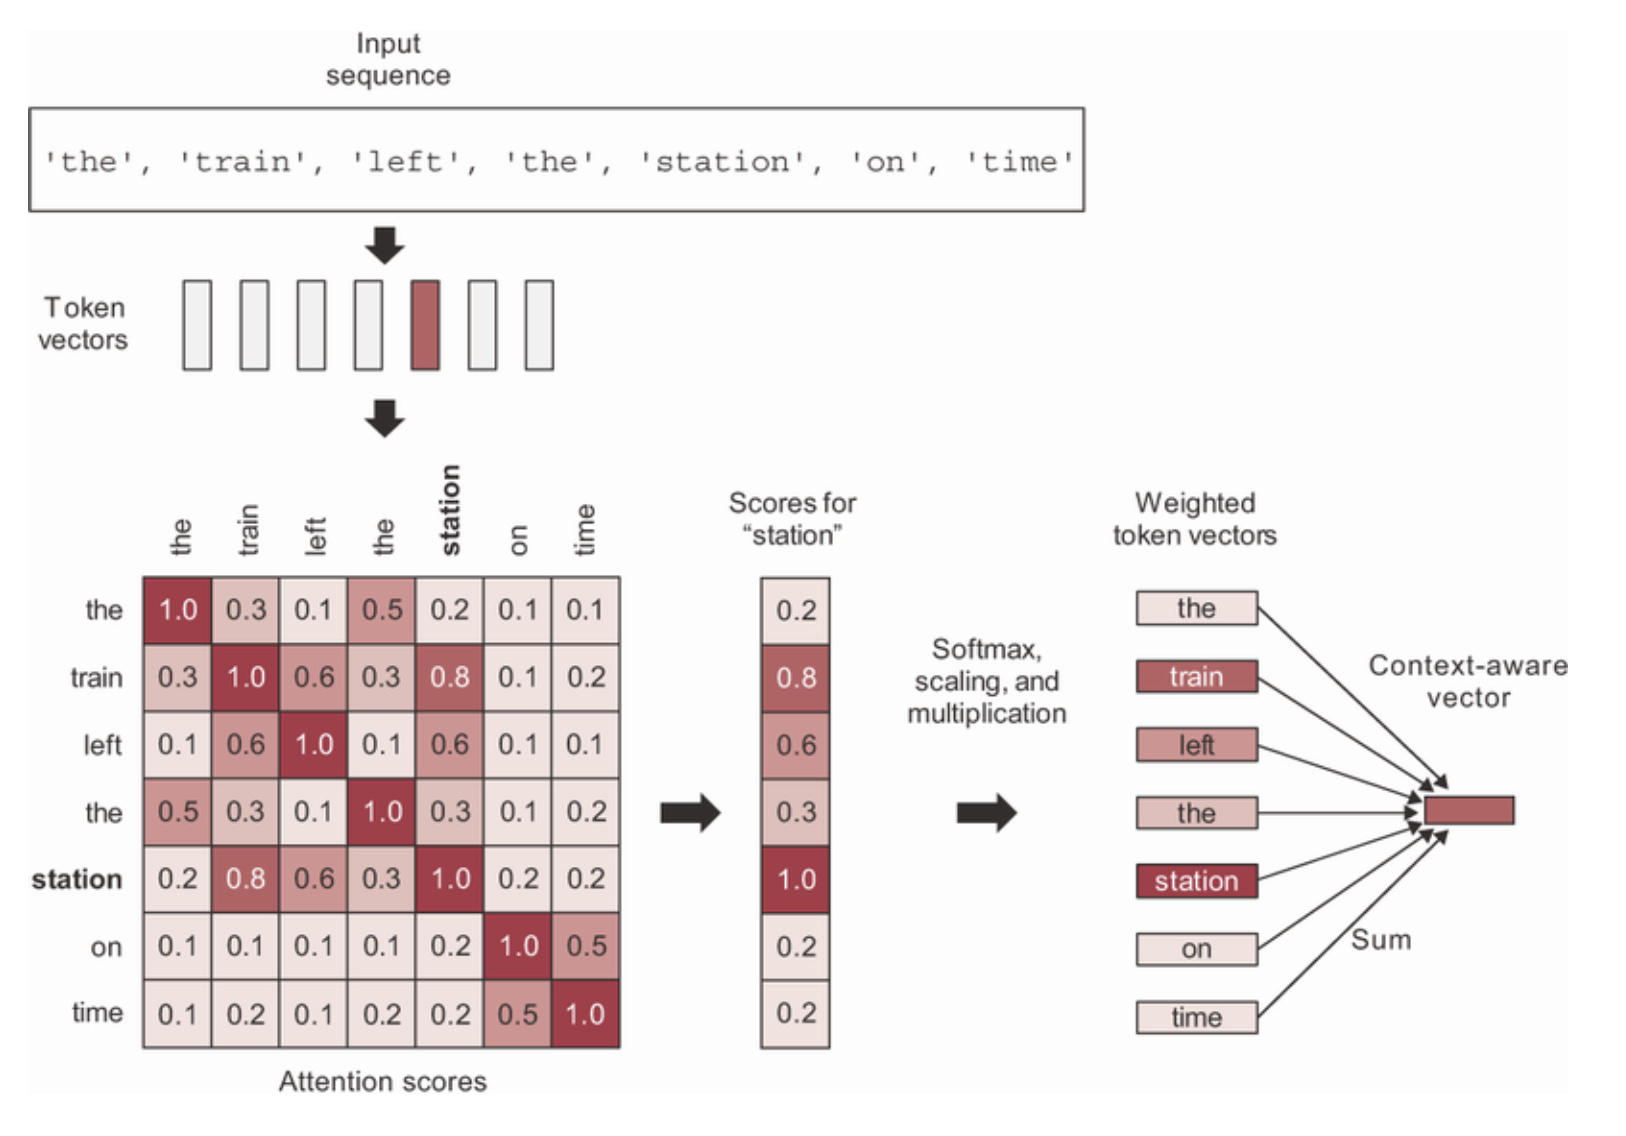



Step 1 is to compute relevancy scores between the vector for “station” and every other word in the sentence. These are our “attention scores.” We’re simply going to use the dot product between two word vectors as a measure of the strength of their relationship. It’s a very computationally efficient distance function, and it was already the standard way to relate two word embeddings to each other long before Transformers. In practice, these scores will also go through a scaling function and a softmax, but for now, that’s just an implementation detail.

Step 2 is to compute the sum of all word vectors in the sentence, weighted by our relevancy scores. Words closely related to “station” will contribute more to the sum (including the word “station” itself), while irrelevant words will contribute almost nothing. The resulting vector is our new representation for “station”: a representation that incorporates the surrounding context. In particular, it includes part of the “train” vector, clarifying that it is, in fact, a “train station.”

You’d repeat this process for every word in the sentence, producing a new sequence of vectors encoding the sentence.

### Encoder Model



We will now set up a DNN with a Transformer Encoder (as described in lecture).

In the next code cell, we have defined a TokenAndPositionEmbedding layer and a TransformerEncoder layer.

To use these layers flexibly, we have used the Keras subclassing API. If you aren't familiar with classes and objected-oriented programming, feel free to skip this code cell. The important thing is to learn how to use the TokenAndPositionEmbedding and TransformerEncoder layers as "lego blocks" and for that, you don't need to understand exactly how those blocks are constructed.

In [ ]:
from keras import ops
from keras import layers
from keras import ops

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim,
                                             output_shape=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Step 1: Make some design choices. 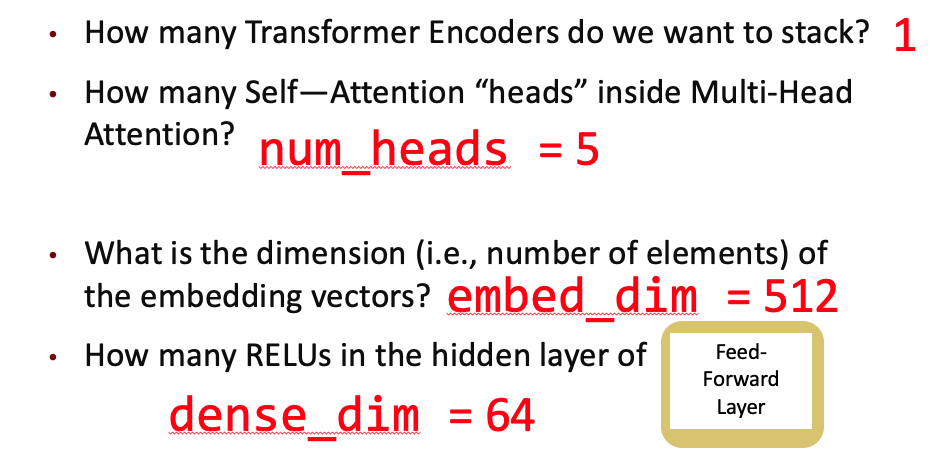

In [ ]:
# Params
embed_dim = 512
dense_dim = 64
num_heads = 5

We will first set up the token embedding and position embedding tables (see below to refresh your memory) as a Keras TokenandPositionEmbeddinglayer.

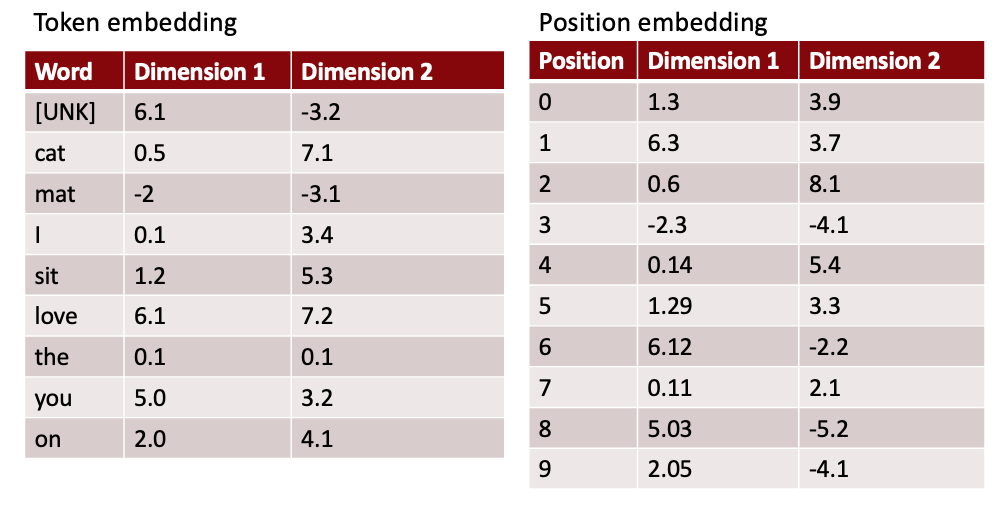

This is the Transformer Encoder.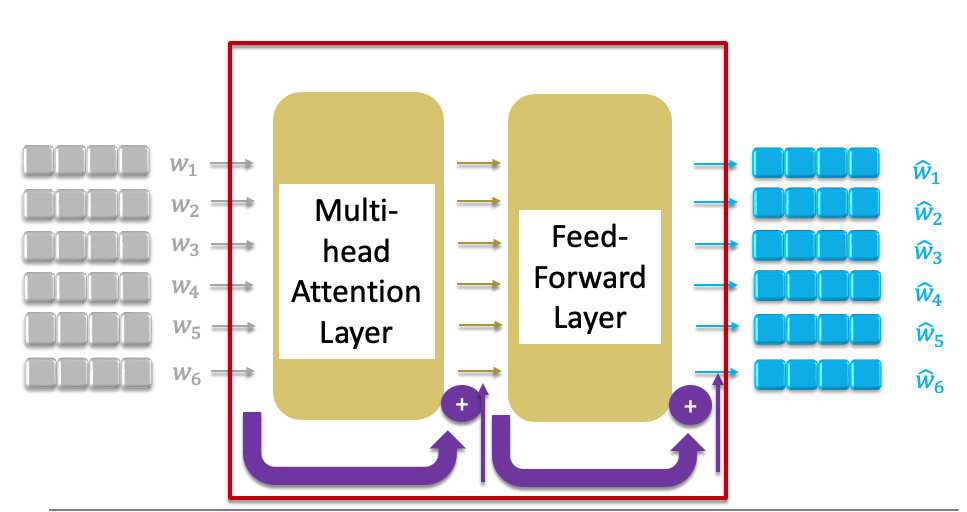

We then create the full Keras model. 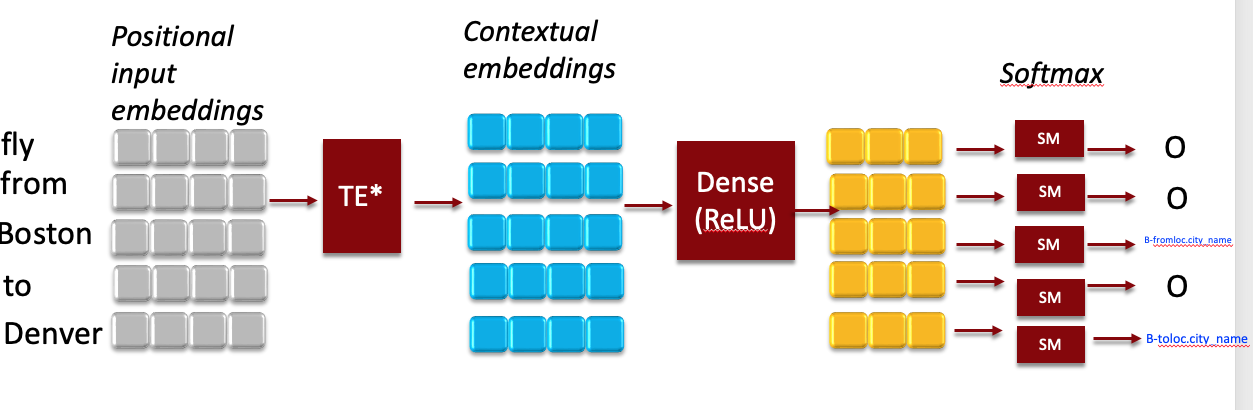

In [ ]:
# Embedding and Masking
inputs = keras.layers.Input(shape=(max_query_length,))

embedding = TokenAndPositionEmbedding(max_query_length,
                                query_vocab_size,
                                embed_dim)
x = embedding(inputs) #grey vectors

encoder_out = TransformerEncoder(embed_dim,
                                 dense_dim,
                                 num_heads)(x)

#encoder_out = BLUE!!! vectors

# Classifier
units = 128
x = keras.layers.Dense(units, activation='relu')(encoder_out)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(slot_vocab_size, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, 30, 512)             │         470,016 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder                  │ (None, 30, 512)             │       5,319,232 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 30, 128)             │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 30, 125)             │          16,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,871,037 (22.40 MB)

 Trainable params: 5,871,037 (22.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["sparse_categorical_accuracy"])

In [ ]:
BATCH_SIZE = 64
epochs = 10

# Fit
history = model.fit(source_train, target_train,
                 batch_size=BATCH_SIZE,
                 epochs=epochs)

Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 88ms/step - loss: 0.9171 - sparse_categorical_accuracy: 0.8270
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.1514 - sparse_categorical_accuracy: 0.9564
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.1092 - sparse_categorical_accuracy: 0.9656
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0817 - sparse_categorical_accuracy: 0.9749
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0623 - sparse_categorical_accuracy: 0.9816
Epoch 6/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0527 - sparse_categorical_accuracy: 0.9843
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0421 - sparse_categorical_accuracy: 0.9875
Epoch 8/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0338 - sparse_categorical_accuracy: 0.9896
Epoch 9/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0272 - sparse_categorical_accuracy: 0.9918
Epoch 10/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 0.0

In [ ]:
print(f"Test set accuracy: {model.evaluate(source_test, target_test)[1]:.2%}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0691 - sparse_categorical_accuracy: 0.9867
Test set accuracy: 98.72%


Let's write a little helper function to calculate the accuracy on just the non-O slots.

In [ ]:
# Metrics
def slot_filling_accuracy(actual, predicted, only_slots=False):
  not_padding = np.not_equal(actual, 0) #+ np.not_equal(predicted, 0)

  if only_slots:
    non_slot_token = text_vectorization_slots(['O']).numpy()[0, 0]
    slots = np.not_equal(actual, non_slot_token)
    correct_predictions = np.equal(actual, predicted)[not_padding * slots]
  else:
    correct_predictions = np.equal(actual, predicted)[not_padding]

  sample_length = len(correct_predictions)

  weights = np.ones(sample_length)

  return np.dot(correct_predictions, weights) / sample_length


In [ ]:
predicted = np.argmax(model.predict(source_test), axis=-1).reshape(-1)
actual = target_test.numpy().reshape(-1)

acc = slot_filling_accuracy(actual, predicted, only_slots=False)
acc_slots = slot_filling_accuracy(actual, predicted, only_slots=True)

print(f'Accuracy on slots = {acc_slots:.3f}')

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
Accuracy on slots = 0.914


Now we get 91% accuracy on the slots and 98% accuracy in general. This is much better!!


Let's see some examples:

In [ ]:
def predict_slots_query(query):
  sentence = text_vectorization_query([query])

  prediction = np.argmax(model.predict(sentence), axis=-1)[0]

  inverse_vocab = dict(enumerate(text_vectorization_slots.get_vocabulary()))
  decoded_prediction = " ".join(inverse_vocab[int(i)] for i in prediction)
  return decoded_prediction

examples = [
            'from los angeles',
            'to los angeles',
            'from boston',
            'to boston',
            'cheapest flight from boston to los angeles tomorrow',
            'what is the airport at orlando',
            'what are the air restrictions on flights from pittsburgh to atlanta for the airfare of 416 dollars',
            'flight from boston to santiago',
            'flight boston to santiago'
]

for e in examples:
  print(e)
  print(predict_slots_query(e))
  print()

from los angeles
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
O B-fromloc.city_name I-fromloc.city_name                           

to los angeles
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
O B-fromloc.city_name I-fromloc.city_name                           

from boston
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
O B-fromloc.city_name                            

to boston
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
O B-fromloc.city_name                            

cheapest flight from boston to los angeles tomorrow
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
B-cost_relative O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name B-depart_date.today_relative                      

what is the airport at orlando
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
O O O O O B-city_name                        

what are the air restrictions on flights from pittsburgh to atlanta for the airfare of 416 dollars
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
O O O O O O O O B-fromloc.city_name O B-toloc.city_name O O O O B-fare_amount 

Even though 'Santiago' is not a city that is present in the training data set, it is still capable of recognizing it as a destination city name just by context!